**Latihan Membuat Model Klasifikasi Gambar**

**Tujuan** <br>
Tahap awal sebelum kita membangun sebuah model machine learning adalah mendefinisikan *problem statement* yang ingin kita selesaikan. Pada tahap ini kita menentukan apa masalah yang ingin diselesaikan dan bagaimana implementasi dari model jaringan saraf tiruan dapat menyelesaikan masalah tersebut. Setelah kita memahami masalah, kita dapat mengembangkan model jaringan saraf tiruan sebagai sebuah solusi.

Pada latihan kali ini kita akan membuat sebuah model untuk mengklasifikasi gambar sebuah kamar dan memprediksi apakah kamar tersebut rapi atau berantakan. Pada akhir latihan Anda dapat menguji model yang telah dibuat dengan menggunakan gambar kamar Anda sendiri. Keren, bukan?

**Tahapan Latihan** <br>
Tentunya machine learning selalu membutuhkan data. Pada tahap awal kita perlu memahami dataset yang kita miliki terlebih dahulu. Beberapa hal yang perlu diketahui adalah format dari data, jumlah sampel, dan berapa jumlah label. Selain itu, kita juga perlu memastikan apakah dataset tersebut merupakan data kontinu (masalah regresi) atau data diskrit (masalah klasifikasi).

Dataset yang kita gunakan memiliki 192 sampel data latih yang terdiri dari 96 sampel gambar ruangan rapi dan 96 sampel gambar ruangan berantakan.
![Alt text](https://dicoding-web-img.sgp1.cdn.digitaloceanspaces.com/original/academy/dos:eada20dc23d92909f3c1fe2b91e4126b20211126105827.jpeg "a title")

Tahapan latihan kali ini adalah:

1. Memastikan TensorFlow yang digunakan di Google Colab adalah versi di atas 2.0.
2. Mengunduh dataset dan melakukan extract file dengan metode unzip.
3. Menampung direktori setiap kelas pada direktori train dan validasi ke dalam variabel.
4. Pre-processing data dengan image augmentation.
5. Mempersiapkan data latih yang akan dipelajari oleh model.
6. Membangun arsitektur model dengan Convolutional Neural Network (CNN).
7. Compile dan latih model dengan model.compile dan model.fit hingga mendapatkan akurasi yang diinginkan.
8. Menguji model yang telah dibuat dengan menggunakan gambar yang belum dikenali oleh model.

Hal pertama yang perlu dilakukan adalah memastikan bahwa versi TensorFlow yang Anda gunakan adalah versi 2 ke atas.

In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


Tahap selanjutnya adalah mempersiapkan dataset yang akan digunakan. Anda dapat mengunduh dataset tersebut dengan menggunakan perintah berikut.

!wget --no-check-certificate \
  https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip \
  -O ./resources/sample_data/messy_vs_clean_room.zip

Kode di bawah ini berfungsi untuk mengekstrak data yang sebelumnya kita unduh. Lalu kita mendefinisikan nama direktori untuk data latih dan data validasi.

In [4]:
# Melakukan ekstraksi pada file zib
import zipfile,os
public_zip = "./resources/sample_data/messy_vs_clean_room"
zip_ref = zipfile.ZipFile(f"{public_zip}.zip", 'r')
zip_ref.extractall(public_zip)
zip_ref.close()

base_dir = f"{public_zip}/images"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Setelah Anda jalankan kode di atas, perhatikanlah, direktori data latih dan data validasi masing-masing memiliki sub-direktori clean dan messy. Setiap sub-direktori menyimpan gambar yang sesuai dengan nama sub-direktori tersebut. Jadi, pada sub-direktori ‘clean’ terdapat gambar-gambar ruangan yang rapi dan pada sub-direktori ‘messy’ terdapat gambar-gambar ruangan yang berantakan.

In [5]:
os.listdir(f"{public_zip}/images/train")

['clean', 'messy']

In [6]:
os.listdir(f"{public_zip}/images/val")

['clean', 'messy']

Langkah selanjutnya, kita akan menerapkan ImageDataGenerator untuk data latih dan data validasi. ImageDataGenerator merupakan sebuah fungsi yang sangat berguna untuk mempersiapkan data latih dan data validasi. Beberapa kemudahan yang disediakan ImageDataGenerator antara lain, preprocessing data, pelabelan sampel otomatis, dan augmentasi gambar.

Augmentasi gambar merupakan sebuah teknik yang dapat digunakan untuk memperbanyak data latih dengan cara menduplikasi gambar yang telah ada dengan menambahkan variasi tertentu. Anda akan mempelajari lebih dalam terkait teknik ini pada kelas “Belajar Pengembangan Machine Learning”. Anda juga dapat melihat detail mengenai augmentasi gambar menggunakan ImageDataGenerator pada [tautan](https://keras.io/preprocessing/image/) berikut. 

Kode berikut menunjukkan proses augmentasi gambar pada setiap sampel di dataset.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

Selanjutnya, siapkan data latih dan validasi dari kumpulan data gambar yang di-load dalam memori melalui fungsi flow() berikut.

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir, #directory data latih
    target_size=(150, 150), # mengubah resolusi gambar menjadi 150x150 px
    batch_size=4,
    # karena ini merupakan masalah klasifikasi 2 kelas maka, menggunakan class_mode 'binary'
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, # directory dari data validasi
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary'
)

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Setelah data siap, kita bisa membangun model Convolutional Neural Network (CNN). Pembuatan model CNN pada keras mirip dengan pembuatan model Multi Layer Perceptron (MLP) yang dibahas pada modul sebelumnya. Perbedaannya terdapat pada empat lapis layer konvolusi dan max pooling. 

Anda tentu masih ingat bahwa fungsi dari layer konvolusi adalah untuk mengekstraksi atribut pada gambar. Sedangkan layer max pooling berguna untuk mereduksi resolusi gambar sehingga proses pelatihan model lebih cepat. Nah, pada model CNN, proses klasifikasi gambar hanya berfokus pada atribut-atribut unik yang membedakan tiap kategori. Sehingga, teknik ini dinilai lebih optimal dibandingkan hanya menggunakan model MLP yang membedakan tiap kategori dengan melihat keseluruhan piksel-piksel pada gambar.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

Usai membuat model, kita bisa menggunakan fungsi summary() untuk melihat summary dari arsitektur model yang telah kita buat.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Anda mungkin bertanya-tanya, bagaimana membaca model summary di atas? Jangan khawatir, yuk kita bahas bersama.

Berdasarkan hasil summary di atas, model yang kita buat terdiri dari empat lapis Convolutional dan MaxPoling layer, sebuah flatten layer, serta dua buah dense layer. Ingatlah bahwa dense layer terakhir merupakan output layer. Pada kasus klasifikasi biner, output model merupakan angka tunggal antara 0 dan 1. Sehingga, kita set dense layer terakhir = 1. Sementara itu, kolom “Param #” berisi informasi mengenai jumlah parameter pada tiap layer.

Selanjutnya, kolom “Output Shape” berisi informasi ukuran output yang dihasilkan tiap layer. Jika diperhatikan, ukuran input gambar yang telah didefinisikan sebelumnya adalah sebesar (150, 150). Tapi pada convolutional layer pertama, setiap satu input gambar akan menghasilkan ukuran output (148, 148) sebanyak 32 gambar. Ukuran tersebut berkurang karena kita menggunakan filter dengan ukuran (3, 3) dengan jumlah filter sebanyak 32 filter. Sehingga, tiap satu input gambar akan menghasilkan 32 gambar baru dengan ukuran (148, 148). 

Kemudian, resolusi tiap gambar akan diperkecil dengan tetap mempertahankan informasi pada gambar menggunakan MaxPoling layer yang berukuran (2, 2). Hal ini  akan menghasilkan ukuran output gambar sebesar (74, 74). Nah, proses tersebut juga berlaku untuk Convolutional dan MaxPoling layer yang lain. 

Berikutnya, mari perhatikan flatten layer. Output dari MaxPoling layer terakhir yang terdiri dari 512 gambar dengan ukuran (7, 7) akan diubah ke dalam bentuk array 1D (tensor 1D). Hal ini  akan menghasilkan output berukuran (25088). 

Nah, output tersebut kemudian masuk ke dalam dense layer pertama yang memiliki 512 neuron. Sehingga, ia akan menghasilkan output dengan ukuran (512). Selanjutnya, output ini akan masuk pada dense layer kedua yang memiliki 1 neuron sehingga akan menghasilkan output dengan ukuran (1). Output dari layer terakhir inilah yang digunakan sebagai hasil akhir model untuk kasus klasifikasi biner.

Selamat! Sampai di sini, Anda sudah memahami penjelasan mengenai parameter-parameter dalam model summary. Mari kita lanjutkan proses pembuatan model ke tahap berikutnya.

Setelah membuat arsitektur model CNN, tahap selanjutnya adalah melakukan compile model tersebut menggunakan fungsi compile(). Pada tahap ini, kita juga menentukan loss function serta optimizer yang akan digunakan. Loss function yang digunakan pada kasus klasifikasi biner adalah "binary_crossentropy". Selain itu, optimizer yang digunakan  pada kasus ini adalah "Adam optimizer". Adam optimizer dipilih karena mudah diterapkan, lebih efisien secara komputasi dan kebutuhan memori yang lebih kecil.

In [11]:
# Compile model dengan 'Adam' optimizer loss function 'binary_crossentropy'
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
    )

Nah, tahap terakhir dari pembuatan model adalah proses yang disebut sebagai model fitting. Ia merupakan proses untuk melatih model pada data masukan dan label yang bersesuaian. Pada proses ini, kita memasukkan data latih pada jaringan Neural Network yang telah kita buat sebelumnya. 

Hal yang harus didefinisikan pada tahap ini adalah loss function dan optimizer. Kemudian, kita mulai proses pelatihan model dengan memanggil fungsi fit(). 

Dengan menggunakan ImageDataGenerator, kita tidak perlu memasukkan parameter gambar dan labelnya. Image data generator secara otomatis melabeli gambar sesuai dengan direktorinya. Sebagai contoh,  sebuah gambar yang terdapat di direktori clean, akan diberi label “clean” oleh ImageDataGenerator secara otomatis.

In [12]:
# latih model dengan model.fit 
model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=20, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/20


25/25 - 11s - loss: 0.7649 - accuracy: 0.4100 - val_loss: 0.6930 - val_accuracy: 0.5000 - 11s/epoch - 437ms/step
Epoch 2/20
25/25 - 6s - loss: 0.6935 - accuracy: 0.4700 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 237ms/step
Epoch 3/20
25/25 - 6s - loss: 0.6935 - accuracy: 0.4700 - val_loss: 0.6928 - val_accuracy: 0.5500 - 6s/epoch - 234ms/step
Epoch 4/20
25/25 - 6s - loss: 0.6949 - accuracy: 0.5400 - val_loss: 0.6914 - val_accuracy: 0.5000 - 6s/epoch - 250ms/step
Epoch 5/20
25/25 - 7s - loss: 0.6928 - accuracy: 0.5100 - val_loss: 0.6917 - val_accuracy: 0.5000 - 7s/epoch - 281ms/step
Epoch 6/20
25/25 - 6s - loss: 0.6950 - accuracy: 0.4700 - val_loss: 0.6721 - val_accuracy: 0.5000 - 6s/epoch - 258ms/step
Epoch 7/20
25/25 - 5s - loss: 0.6956 - accuracy: 0.4100 - val_loss: 0.6932 - val_accuracy: 0.5000 - 5s/epoch - 207ms/step
Epoch 8/20
25/25 - 6s - loss: 0.6930 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 238ms/step
Epoch 9/20
25/25 - 5

Sampai di sini, proses training telah selesai. Anda telah berhasil membuat model machine learning dengan CNN untuk mengklasifikasi gambar ruangan yang bersih dan berantakan. Selamat!

Setelah berhasil membuat model, Anda tentu ingin menguji model tersebut untuk memprediksi gambar baru (gambar yang belum dikenal oleh model sebelumnya). Potongan program berikut memungkinkan kita secara interaktif memilih sebuah gambar. Kemudian, gambar tersebut akan diolah terlebih dahulu sebelum dimasukkan ke model untuk diprediksi. 

Sebelum menerapkan kode ini, pastikan Anda telah memiliki contoh gambar yang akan diuji. Anda dapat mencari dan mengunduh gambar tersebut dari mesin pencari Google. Atau, Anda dapat menggunakan gambar dari tautan berikut.

1/1 [==============================] - 0s 339ms/step
Bedroom is MESSY


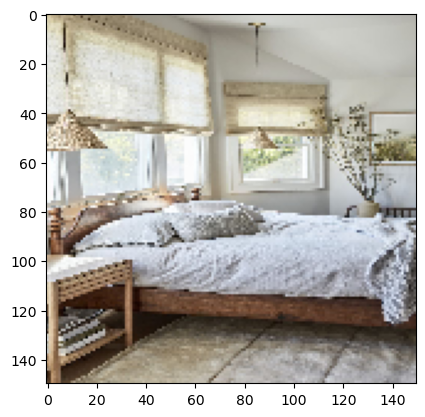

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# path = input("Path Image: ")
path = "./resources/sample_data//image/clean-bedroom.jpg"
img = image.load_img(path, target_size=(150,150))

implot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)
if classes==0:
    print("Bedroom is CLEAN")
else:
    print("Bedroom is MESSY")